Test with Acropora abrolhosensis https://www.marinespecies.org/aphia.php?p=taxdetails&id=288182
aphiaID = 288182  
urn = urn:lsid:marinespecies.org:taxname:288182

In [1]:
import json
from urllib.request import urlopen
import pandas as pd

In [18]:
base = 'https://api.obis.org/v3/'

aphiaID = '288182'

fields = ['decimalLatitude','decimalLongitude','occurrenceID','id',
          'datasetName','dataset_id','eventDate','species','aphiaID',
          'date_year']

f = "%2C".join([f"{v}" for v in fields])

occurrence_id = 'occurrence?taxonid={}&fields={}&size=500'.format(aphiaID, f)

#taxon_id = 'taxon/{}'.format(aphiaID)
#taxon_sn = 'taxon/{}'.format(scientificname)

url = '{}{}'.format(base,occurrence_id)

url

'https://api.obis.org/v3/occurrence?taxonid=288182&fields=decimalLatitude%2CdecimalLongitude%2CoccurrenceID%2Cid%2CdatasetName%2Cdataset_id%2CeventDate%2Cspecies%2CaphiaID%2Cdate_year&size=500'

In [19]:
response= urlopen(url)

data_json = json.loads(response.read())
data_json['results']

data = pd.DataFrame(data_json['results'])
data.head()

,species,dataset_id,aphiaID,decimalLongitude,decimalLatitude,id,occurrenceID,date_year,eventDate,datasetName
0,Acropora abrolhosensis,c380d2c9-98b3-48cf-af6c-56a88b81f1a4,288182,116.629997,-20.530001,02d8e166-2cc9-47aa-bf75-edc4bae204ec,Hexacorals_Fautin_033632,NaN,NaN,NaN
1,Acropora abrolhosensis,6078be2d-e1af-47b3-bd70-3956dd95f664,288182,122.233330,-8.616660,05cf62e5-134a-4caf-b43c-8b5adefaa3be,urn:lsid:ozcam.taxonomy.org.au:QM.Corals:G49367,1994.0,1994-10-30,NaN
2,Acropora abrolhosensis,c380d2c9-98b3-48cf-af6c-56a88b81f1a4,288182,113.769997,-28.730000,07f30fe4-c4f5-4112-83a7-34d6124d8970,Hexacorals_Fautin_062964,NaN,NaN,NaN
3,Acropora abrolhosensis,0a6c216b-0abe-44d2-a45c-43d9611e2a03,288182,119.200000,-17.200000,0847c409-f045-4e4b-957f-9725715ddf32,Z7273,1982.0,1982-07-01,NaN
4,Acropora abrolhosensis,6c813a6c-86f7-4d45-beb5-33eebd8de938,288182,122.500000,-0.500000,125870ba-d456-4d99-88ce-1646d3d338e3,77633,NaN,NaN,South Pacific Regional Fisheries Management Or...


In [21]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.decimalLongitude, data.decimalLatitude),
    crs="EPSG:4326")

<AxesSubplot:>

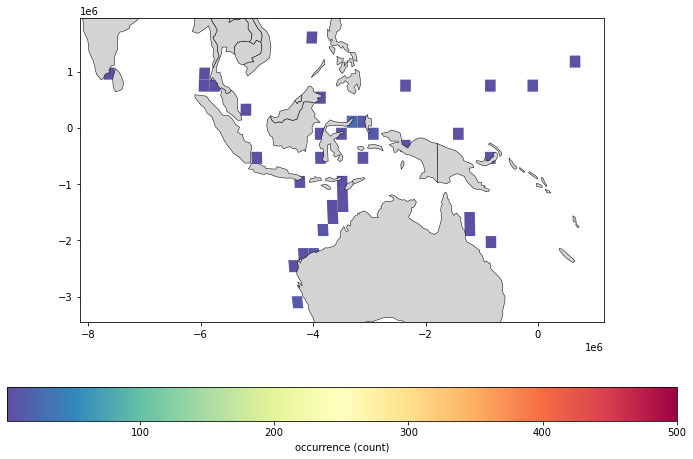

In [43]:
import numpy as np
import shapely
import matplotlib.pyplot as plt

# total area for the grid
xmin, ymin, xmax, ymax= [-180., -90., 180., 90]
# how many cells across and down
n_cells=180
cell_size = (xmax-xmin)/n_cells
# projection of the grid
#crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
        
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs="EPSG:4326")
    
# ax = gdf.plot(markersize=.1, figsize=(12, 8),)# column='dob', cmap='jet')
# plt.autoscale(False)
# cell.plot(ax=ax, facecolor="none", edgecolor='grey')
# ax.axis("off")

merged = gpd.sjoin(gdf, cell, how='left', op='within')

# make a simple count variable that we can sum
merged['n_occur'] = 1
# Compute stats per grid cell -- aggregate fires to grid cells with dissolve
dissolve = merged.dissolve(by="index_right", aggfunc="count")
# put this into cell
cell.loc[dissolve.index, 'n_occur'] = dissolve.n_occur.values


crs = pycrs.parse.from_esri_code(54030)
crs.geogcs.prime_mer.value = 160.0
crs_str = crs.to_proj4()#.replace("lon_0=0","lon_0=-180")

ax = cell.to_crs(crs_str).plot(column='n_occur', figsize=(12, 8), cmap='Spectral_r', vmin=1, vmax=500, edgecolor=None, legend=True,
              legend_kwds={'label': "occurrence (count)",
                                            'orientation': "horizontal"},
              )

plt.autoscale(False)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.to_crs(crs_str).plot(ax=ax, 
                               color='lightgrey', 
                               edgecolor='black',
                               linewidth=.5, 
                               legend=True,
                               legend_kwds={'label': "occurrence (count)",
                                            'orientation': "horizontal"},
                               )

In [20]:
data.shape

(167, 10)

shift map

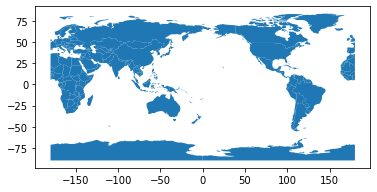

In [31]:
from shapely.geometry import LineString
from shapely.ops import split
from shapely.affinity import translate
import geopandas

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

def shift_map(shift):
    shift -= 180
    moved_map = []
    splitted_map = []
    border = LineString([(shift,90),(shift,-90)])
    for row in world["geometry"]:
        splitted_map.append(split(row, border))
    for element in splitted_map:
        items = list(element)
        for item in items:
            minx, miny, maxx, maxy = item.bounds
            if minx >= shift:
                moved_map.append(translate(item, xoff=-180-shift))
            else:
                moved_map.append(translate(item, xoff=180-shift))
    gdf = geopandas.GeoDataFrame({"geometry":moved_map})
    fig, ax = plt.subplots()
    gdf.plot(ax=ax)
    plt.show()
    
shift_map(180)

In [ ]:
import geopandas as gpd

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.decimalLongitude, data.decimalLatitude))

ax = world.plot(
    color='white', edgecolor='black')

gdf.plot(ax=ax, color='red')

In [ ]:
import geoplot

ax = geoplot.kdeplot(
    gdf,
    shade=True, 
    cmap='viridis',
    projection=geoplot.crs.WebMercator(),
    figsize=(12,12),
    )

geoplot.pointplot(gdf, s=1, color='black', ax=ax)
geoplot.webmap(gdf, ax=ax, legend=True)

#geoplot.polyplot(gdf, ax=ax, zorder=1)

In [45]:
import pycrs
crs = pycrs.parse.from_esri_code(54030)

In [44]:
crs.geogcs.prime_mer.value

160.0

In [46]:
crs.geogcs.prime_mer.value

0

<AxesSubplot:>

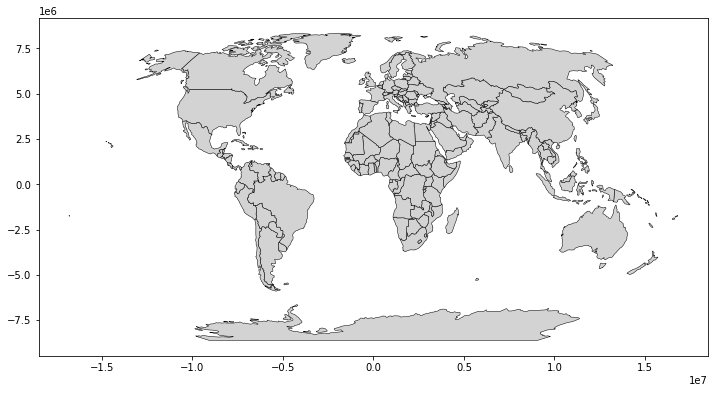

In [61]:
crs = pycrs.parse.from_esri_code(54030)
crs.geogcs.prime_mer.value = 0.0
crs_str = crs.to_proj4()

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.to_crs(crs_str).plot(figsize=(12, 8),
                           color='lightgrey', 
                           edgecolor='black',
                           linewidth=.5, 
                           legend=True,
                           legend_kwds={'label': "occurrence (count)",
                                        'orientation': "horizontal"},
                           )